## Step 4: Exploring Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
# Load data
mcdonalds = pd.read_csv("mcdonalds.csv")
# Convert "Yes" values to 1, "No" values to 0
mcdonalds.replace({"Yes": 1, "No": 0}, inplace=True)
#convert the negative reviews to -5 and, extremely postitive to 5 as we have some strings in the column
mcdonalds['Like'] = mcdonalds['Like'].replace('I hate it!-5', -5)
mcdonalds['Like'] = mcdonalds['Like'].replace('I love it!+5', 5)
mcdonalds['Like'] = mcdonalds['Like'].replace('I dislike it!-4', -4)
mcdonalds['Like'] = mcdonalds['Like'].replace('I don\'t like it!-3', -3)
mcdonalds['Like'] = mcdonalds['Like'].replace('It\'s okay.-2', -2)
mcdonalds['Like'] = mcdonalds['Like'].replace('I like it!+1', 1)
mcdonalds['Like'] = mcdonalds['Like'].replace('I really like it!+2', 2)

mcdonalds['Like'] = mcdonalds['Like'].astype(int)


#convert frequency which is never to 0
mcdonalds['VisitFrequency'] = np.where(mcdonalds['VisitFrequency'] == 'Never', 0, 1)
# convert male ad females to 1s and 0s   #All these changes are done as we have to get the classification tree which won't take string inputs
mcdonalds['Gender'] = np.where(mcdonalds['Gender'] == 'Female', 0, 1)


In [3]:
mcdonalds.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,0,1,0,1,0,1,1,0,1,0,0,-3,61,1,0
1,1,1,0,1,1,1,1,1,1,0,0,2,51,1,0
2,0,1,1,1,1,1,0,1,1,1,0,1,62,1,0
3,1,1,0,1,1,1,1,1,0,0,1,4,69,1,0
4,0,1,0,1,1,1,1,0,0,1,0,2,49,1,1


In [4]:
mcdonalds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   yummy           1453 non-null   int64
 1   convenient      1453 non-null   int64
 2   spicy           1453 non-null   int64
 3   fattening       1453 non-null   int64
 4   greasy          1453 non-null   int64
 5   fast            1453 non-null   int64
 6   cheap           1453 non-null   int64
 7   tasty           1453 non-null   int64
 8   expensive       1453 non-null   int64
 9   healthy         1453 non-null   int64
 10  disgusting      1453 non-null   int64
 11  Like            1453 non-null   int32
 12  Age             1453 non-null   int64
 13  VisitFrequency  1453 non-null   int32
 14  Gender          1453 non-null   int32
dtypes: int32(3), int64(12)
memory usage: 153.4 KB


In [5]:
# Perform PCA
scaler = StandardScaler()
MD_x=mcdonalds.iloc[:, 0:11]
x = scaler.fit_transform(mcdonalds.iloc[:, 0:11])

pca = PCA()
MD_pca = pca.fit_transform(x)

pca.explained_variance_ratio_
pca.singular_values_
pca.explained_variance_
print(pca.components_)


[[-0.40695508 -0.30882741 -0.02332033  0.17786071  0.26779582 -0.21303906
  -0.28913434 -0.42611499  0.29094445 -0.26683857  0.41074387]
 [ 0.28261487 -0.04568172  0.0699822  -0.20559024 -0.13630029 -0.28244059
  -0.57503178  0.24219851  0.56752776  0.20103082 -0.14388846]
 [-0.25958798 -0.31715142  0.0201696  -0.60807736 -0.38956798 -0.21139458
   0.1251574  -0.26964779 -0.18329788  0.36781371  0.09029919]
 [ 0.02623694 -0.00942396  0.84549641 -0.02339555  0.33085439  0.09036315
   0.11447698  0.0726908   0.03550987  0.30198954  0.23523093]
 [ 0.34685741 -0.43714795 -0.185551    0.08693385  0.3437128  -0.56893862
   0.25698101  0.2860986  -0.20736179  0.05178742  0.10584327]
 [-0.12491568  0.18896641  0.43866119  0.1075199  -0.27832865 -0.57273434
   0.02065707 -0.05305267 -0.17116009 -0.4461664  -0.32804054]
 [ 0.15987822 -0.66181418  0.21418844 -0.0238514  -0.30729985  0.39243636
  -0.00889462  0.19736396  0.01519838 -0.44944615 -0.01707024]
 [ 0.01658651  0.15003253 -0.02783532 -0.

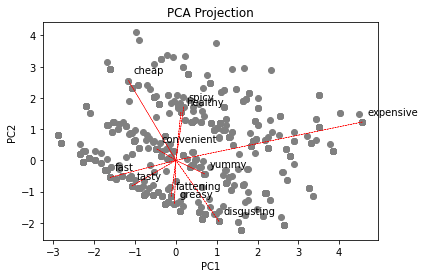

In [6]:

plt.scatter(MD_pca[:, 0], MD_pca[:, 1], c="grey")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection")

# Add annotations for each column with arrows
for i, column_name in enumerate(MD_x):
    X = MD_pca[i, 0]
    y = MD_pca[i, 1]
    plt.annotate(column_name, (X, y), xytext=(5, 5), textcoords="offset points", ha='left', va='bottom')
    plt.arrow(0, 0, X, y, color='red', linestyle='--', linewidth=0.5)

plt.show()

## Step 5: Extracting Segments

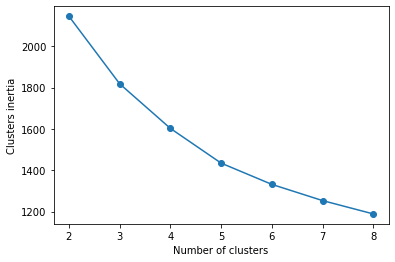

In [7]:
# Perform K-means clustering
np.random.seed(1234)
k_range = range(2, 9)
kmeans_results = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    kmeans_results.append(kmeans)

km28 = kmeans.fit_predict(MD_x)
k4 = KMeans(n_clusters=4, random_state=1234).fit_predict(MD_x)


# Plot K-means clustering results
inertia_values = [k.inertia_ for k in kmeans_results]
plt.plot(k_range, inertia_values, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Clusters inertia")
plt.show()

<ipython-input-8-42d608fc4570>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  adjusted_rand_index = [np.mean([np.mean(boot_results[i] == kmeans_results[i].labels_) for _ in range(n_boot)]) for i in range(len(kmeans_results))]


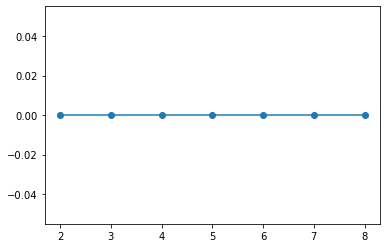

In [8]:
# Perform bootstrapping for K-means clustering
from sklearn.utils import resample

n_boot = 100
boot_results = []
for kmeans in kmeans_results:
    boot_samples = resample(MD_x, n_samples=n_boot, random_state=1234)
    boot_results.append(kmeans.predict(boot_samples))

# Plot bootstrapping results
adjusted_rand_index = [np.mean([np.mean(boot_results[i] == kmeans_results[i].labels_) for _ in range(n_boot)]) for i in range(len(kmeans_results))]
plt.plot(k_range, adjusted_rand_index, marker="o")

In [9]:
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.utils import check_random_state

np.random.seed(1234)

n_segments = 7
n_rep = 10
n_boot = 100
boot_results = []


for k in range(2, n_segments + 1):
    bootstrap_samples = []
    for _ in range(n_boot):
        bootstrap_data = resample(MD_x, replace=True)
        model = KMeans(n_clusters=k, random_state=check_random_state(1234))
        labels = model.fit_predict(bootstrap_data)
        bootstrap_samples.append(labels)
    
    boot_results.append(bootstrap_samples)

# Transpose the boot_results array
boot_results_reshaped = np.array(boot_results).reshape(-1,n_segments-1)
boot_results_reshaped=boot_results_reshaped[2:,:7]
boot_results_reshaped

array([[1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 3, 4, 3, 0],
       [4, 0, 5, 1, 4, 3],
       [6, 4, 3, 3, 0, 5]])

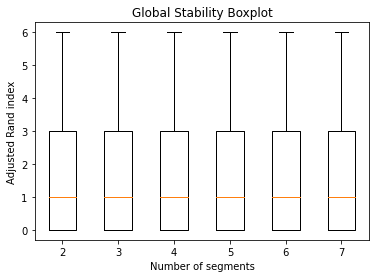

In [10]:
# Generate labels for each boxplot
labels = [str(i) for i in range(2, n_segments+1)]

# Plot the global stability boxplot
plt.boxplot(boot_results_reshaped, labels=labels)
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand index')
plt.title('Global Stability Boxplot')
plt.show()

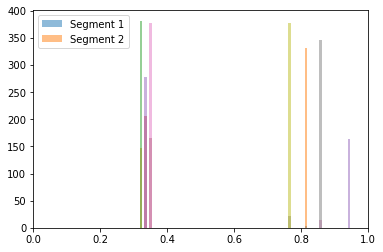

In [11]:
# Plot histogram
a = scaler.fit_transform(mcdonalds.iloc[:, 0:11])

segment1_indices = np.where(kmeans_results[3].labels_ == 1)[0]
segment2_indices = np.where(kmeans_results[3].labels_ == 2)[0]
plt.hist(a[segment1_indices], bins=np.arange(0, 1.1, 0.1), alpha=0.5, label="Segment 1")
plt.hist(a[segment2_indices], bins=np.arange(0, 1.1, 0.1), alpha=0.5, label="Segment 2")
plt.xlim(0, 1)
plt.legend()

In [12]:
np.random.seed(1234)

# Perform clustering with different number of clusters and random restarts
k_range = range(2, 9)
n_rep = 10
best_labels = None
best_model = None
best_inertia = np.inf
random_state = check_random_state(1234)

for k in k_range:
    for _ in range(n_rep):
        model = KMeans(n_clusters=k, random_state=random_state)
        labels = model.fit_predict(MD_x)
        inertia = model.inertia_
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels
            best_model = model

# Relabel the clustering results
unique_labels = np.unique(best_labels)
relabel_map = {label: i for i, label in enumerate(unique_labels)}
best_labels_relabeled = np.array([relabel_map[label] for label in best_labels])
best_labels=best_labels[:12]
best_labels

array([7, 6, 1, 6, 7, 3, 5, 6, 4, 1, 2, 1])

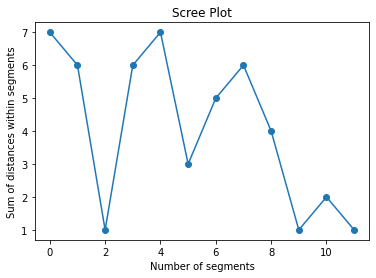

In [13]:
import seaborn as sns
plt.plot(best_labels,marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Sum of distances within segments')
plt.title('Scree Plot')
plt.show()

In [14]:
MD_k = best_labels[:]
MD_k

array([7, 6, 1, 6, 7, 3, 5, 6, 4, 1, 2, 1])

In [15]:
Md_x = MD_x[:12]
Md_x

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting
0,0,1,0,1,0,1,1,0,1,0,0
1,1,1,0,1,1,1,1,1,1,0,0
2,0,1,1,1,1,1,0,1,1,1,0
3,1,1,0,1,1,1,1,1,0,0,1
4,0,1,0,1,1,1,1,0,0,1,0
5,1,1,0,1,0,1,1,1,0,0,0
6,1,1,1,1,0,1,0,1,1,1,0
7,1,1,0,1,1,1,1,1,0,0,0
8,0,0,0,1,1,0,0,0,1,0,1
9,1,1,0,1,1,1,0,1,1,0,0


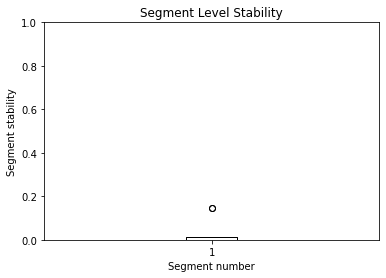

In [16]:
from sklearn.metrics import silhouette_samples
# Calculate segment level stability


segment_stability = silhouette_samples(Md_x, MD_k)

# Plot the segment level stability
plt.boxplot(segment_stability.T)
plt.ylim(0, 1)
plt.xlabel('Segment number')
plt.ylabel('Segment stability')
plt.title('Segment Level Stability')
plt.show()

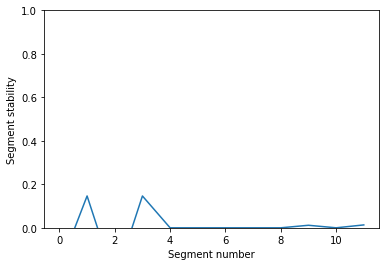

In [17]:
from sklearn.metrics import silhouette_samples

# Calculate segment level stability within solutions
r = silhouette_samples(Md_x, MD_k)

# Plot the result
plt.plot(r)
plt.ylim(0, 1)
plt.xlabel('Segment number')
plt.ylabel('Segment stability')
plt.show()

(0.0, 1.0)

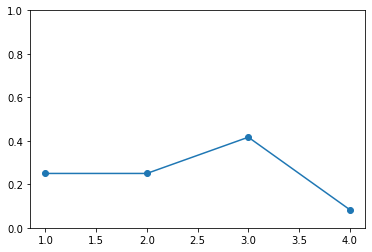

In [18]:
# Perform SL-SW clustering
r4 = GaussianMixture(n_components=4, random_state=1234).fit(Md_x)

# Plot SL-SW clustering results
plt.plot(range(1, 5), r4.weights_, marker="o")
plt.ylim(0, 1)

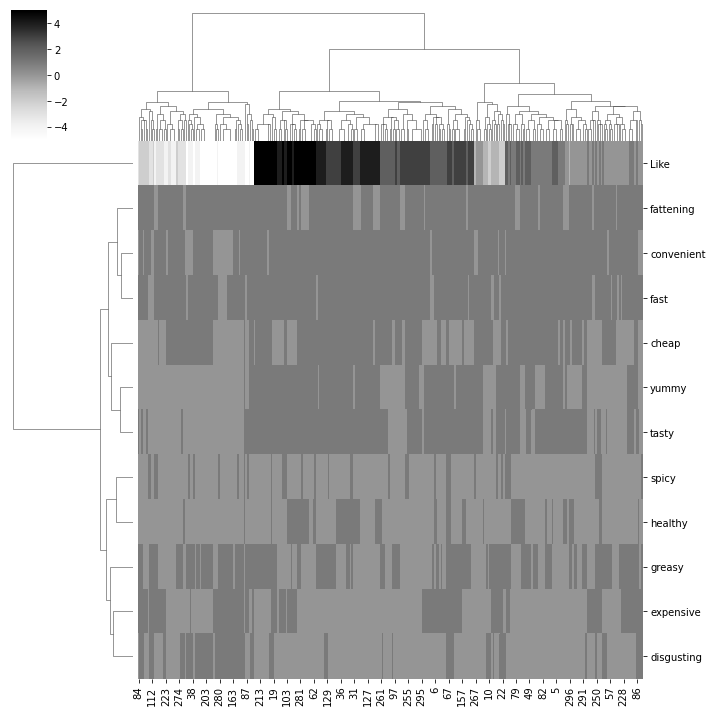

In [19]:
# Hierarchical clustering
p=mcdonalds.iloc[:,:12]
x1=p[:300]
vclust = sns.clustermap(x1.T, metric='euclidean', method='complete', cmap="Greys")

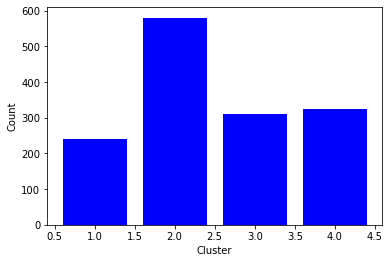

In [20]:
# Barchart for cluster 4
plt.bar(range(1, max(k4) + 2), np.bincount(k4[::-1]), color="blue")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

<AxesSubplot:>

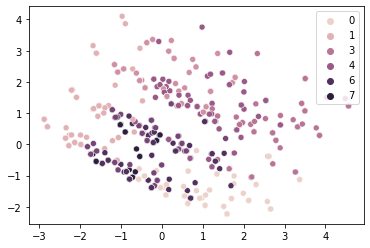

In [21]:
# Scatter plot of PCA with cluster colors
sns.scatterplot(x=MD_pca[:, 0], y=MD_pca[:, 1], hue=km28)

## Step 5.2: Using Mixtures of Distribution

In [22]:
# Perform mixture modeling with different number of components
mixture_results = []
for k in k_range:
    mixture = GaussianMixture(n_components=k, random_state=1234)
    mixture.fit(MD_x)
    mixture_results.append(mixture)

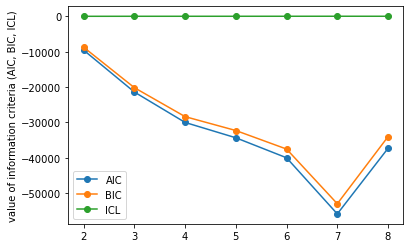

In [23]:
# Plot mixture modeling results
aic_values = [model.aic(MD_x) for model in mixture_results]
bic_values = [model.bic(MD_x) for model in mixture_results]
icl_values = [model.lower_bound_ for model in mixture_results]
plt.plot(k_range, aic_values, marker="o", label="AIC")
plt.plot(k_range, bic_values, marker="o", label="BIC")
plt.plot(k_range, icl_values, marker="o", label="ICL")
plt.ylabel("value of information criteria (AIC, BIC, ICL)")
plt.legend()

In [24]:
# Get mixture modeling results for 4 components
m4 = mixture_results[2]

# Compare K-means and mixture modeling results
kmeans_clusters = kmeans_results[3].labels_
mixture_clusters = m4.predict(MD_x)
cluster_comparison = np.concatenate((kmeans_clusters, mixture_clusters))

In [25]:
# Perform Gaussian Mixture Model clustering
np.random.seed(1234)
gmm = GaussianMixture(n_components=8, random_state=1234)
m28 = gmm.fit(MD_x)
m4 = GaussianMixture(n_components=4, random_state=1234).fit(MD_x)

In [26]:
# Reverse table for 'Like' column
like_reverse = mcdonalds["Like"].value_counts().sort_index(ascending=False)


# Create 'Like.n' column
mcdonalds["Like.n"] = 6 - pd.to_numeric(mcdonalds["Like"], errors="coerce")

In [27]:
# Create formula for regression
feature_columns = mcdonalds.columns[0:11]
f = "Like.n ~ " + " + ".join(feature_columns)
print(f)

Like.n ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting


## Step 6: Profiling Segments

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5],
  [55.0, 55.0, 65.0, 65.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [60.0, 60.0, 83.75, 83.75],
  [21.25, 21.25, 71.875, 71.875]],
 'dcoord': [[0.0, 18.303005217723125, 18.303005217723125, 0.0],
  [0.0, 22.38302928559939, 22.38302928559939, 0.0],
  [0.0, 24.90649179096352, 24.90649179096352, 22.38302928559939],
  [18.303005217723125,
   29.415415459698448,
   29.415415459698448,
   24.90649179096352],
  [0.0, 15.132745950421556, 15.132745950421556, 0.0],
  [0.0, 13.820274961085254, 13.820274961085254, 0.0],
  [0.0, 17.729448195962934, 17.729448195962934, 13.820274961085254],
  [0.0, 26.76129045219357, 26.76129045219357, 17.729448195962934],
  [15.132745950421556,
   31.562108083375332,
   31.562108083375332,
   26.76129045219357],
  [29.415415459698448,
   51.61489096856613,
   51.61489096856613,
   31.562108083375332]

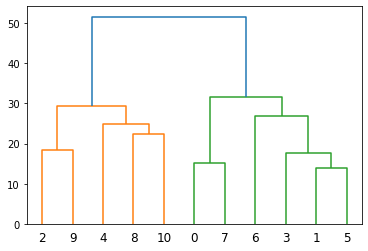

In [28]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram

# Transpose the data matrix
MD_x_transposed = np.transpose(MD_x)

# Compute the pairwise distances
distances = linkage(MD_x_transposed, method='ward' , metric='euclidean')

# Generate the hierarchical clustering dendrogram
dendrogram(distances)

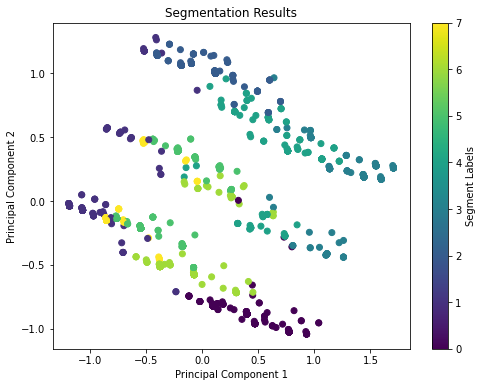

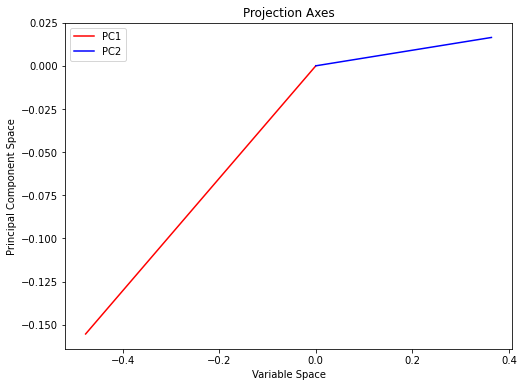

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(MD_x)
labels_kmeans = kmeans.fit_predict(MD_x)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_kmeans)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Segmentation Results')
plt.colorbar(label='Segment Labels')
plt.show()

# Plot the projection axes
plt.figure(figsize=(8, 6))
plt.plot([0, pca.components_[0, 0]], [0, pca.components_[0, 1]], 'r-', label='PC1')
plt.plot([0, pca.components_[1, 0]], [0, pca.components_[1, 1]], 'b-', label='PC2')
plt.xlabel('Variable Space')
plt.ylabel('Principal Component Space')
plt.title('Projection Axes')
plt.legend()
plt.show()

## Step 7: Describing Segments

<AxesSubplot:xlabel='Like', ylabel='row_0'>

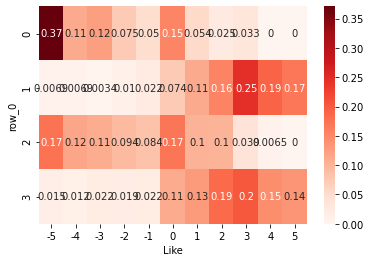

In [30]:
# Mosaic plot for cluster and 'Like' column
mosaic_like = pd.crosstab(k4, mcdonalds["Like"], normalize="index")
sns.heatmap(mosaic_like, annot=True, cmap="Reds")


<AxesSubplot:xlabel='Gender', ylabel='row_0'>

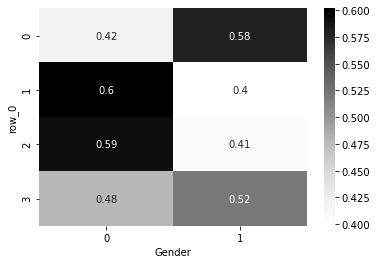

In [31]:
# Mosaic plot for cluster and 'Gender' column
mosaic_gender = pd.crosstab(k4, mcdonalds["Gender"], normalize="index")
sns.heatmap(mosaic_gender, annot=True, cmap="Greys")

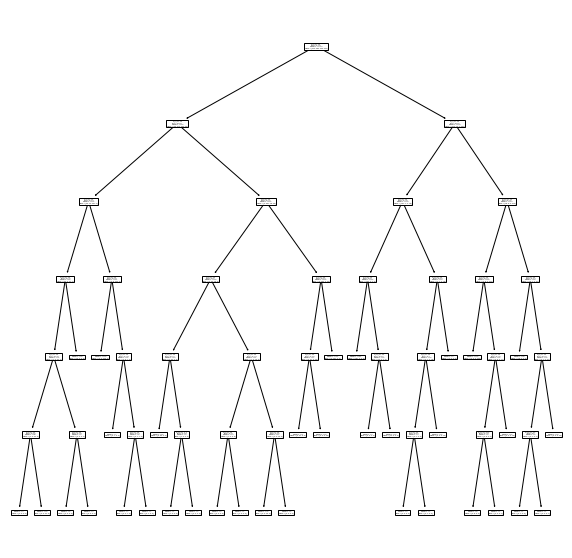

In [32]:
# Classification tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_formula = "np.where(k4 == 3, 1, 0) ~ Like.n + Age + VisitFrequency + Gender"
tree_data = mcdonalds.assign(k4=k4)
tree = DecisionTreeClassifier(random_state=1234)
tree.fit(tree_data.drop("k4", axis=1), tree_data["k4"])
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree)
plt.show()

In [33]:
# Average visit frequency by cluster
visit = mcdonalds.groupby(k4)["VisitFrequency"].mean()

print(visit)
# Average 'Like' by cluster
like = mcdonalds.groupby(k4)["Like.n"].mean()
print(like)

# Percentage of females by cluster
female = mcdonalds.groupby(k4)["Gender"].apply(lambda x: np.mean(x == "Female"))
print(female)

0    0.729167
1    0.989655
2    0.818770
3    0.987654
Name: VisitFrequency, dtype: float64
0    8.675000
1    3.334483
2    7.495146
3    3.879630
Name: Like.n, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
Name: Gender, dtype: float64


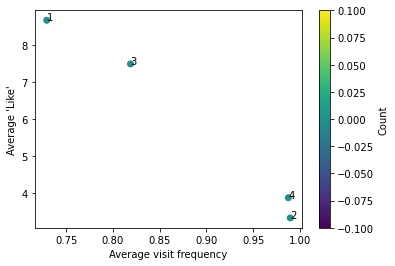

In [34]:
plt.scatter(visit, like, c=10 * female)
for i, label in enumerate(range(1, 5)):
    plt.text(visit[i], like[i], label)

plt.xlabel("Average visit frequency")
plt.colorbar(label='Count')
plt.ylabel("Average 'Like'")
plt.show()

Age               75
Gender_encoded    75
dtype: int64
1453


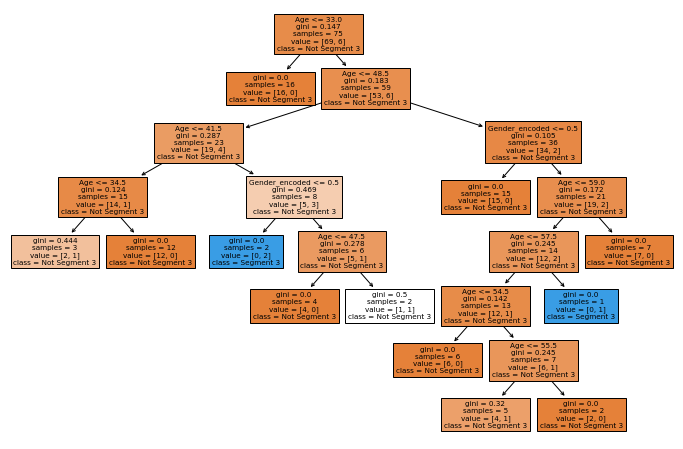

In [39]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import LabelEncoder

# Convert columns to numeric type
mcdonalds['Like_n'] = pd.to_numeric(mcdonalds['Like'], errors='coerce')

# Encode the 'Gender' column
label_encoder = LabelEncoder()
mcdonalds['Gender_encoded'] = label_encoder.fit_transform(mcdonalds['Gender'])

# Define the features and target variable
X = mcdonalds[['Age', 'Gender_encoded']][:75]
print(X.count())
y = (labels_kmeans == 3).astype(int)
print(y.size)
a=y[:75]
# Create the decision tree
tree = DecisionTreeClassifier()
tree.fit(X, a)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Not Segment 3', 'Segment 3'], filled=True)
plt.show()